# Machine Learning-based Water Quality Classification
This project aims to predict water potability using machine learning based on chemical features like pH, hardness, solids, and chloramines. A Random Forest classifier was used, with GridSearchCV for hyperparameter tuning. Due to class imbalance, oversampling was applied. The final model achieved an accuracy of ~85%, effectively classifying water as potable or not.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost lightgbm

In [ ]:
# Data handling and preprocessing
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Modeling and tuning
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Water_Classification/water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Data Visualization

### Class Distribution
A bar plot was created to show the distribution of the binary target variable Potability, which represents whether a water sample is safe to drink (1) or not (0). The analysis revealed a noticeable class imbalance:

- Class 0 (Not Potable): approximately 2000 samples

- Class 1 (Potable): approximately 1200 samples

This imbalance can negatively affect model training, causing the classifier to become biased toward the majority class. To mitigate this issue, oversampling techniques were applied during preprocessing to balance the class distribution and ensure fair learning.

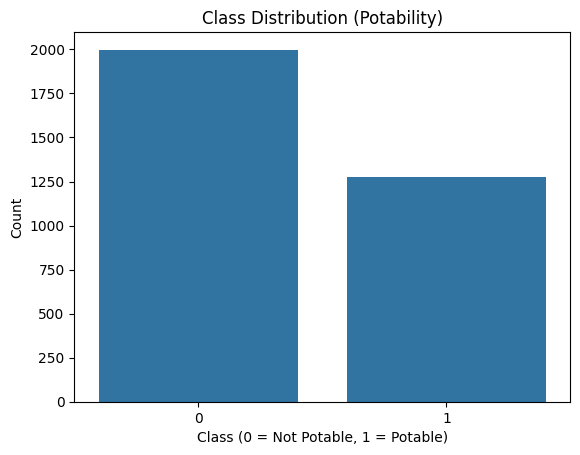

In [ ]:
sns.countplot(x='Potability', data=df)
plt.title("Class Distribution (Potability)")
plt.xlabel("Class (0 = Not Potable, 1 = Potable)")
plt.ylabel("Count")
plt.show()

### Correlation Heatmap
A correlation heatmap was constructed to evaluate the linear relationships between all input features and the target variable. The heatmap displays Pearson correlation coefficients, where values close to +1 or -1 indicate strong positive or negative correlations, respectively, and values near 0 suggest little to no linear correlation.

Key findings from the correlation matrix:
- Most features exhibit very weak correlations with Potability, including ph (0.00), Solids (+0.03), Hardness (~−0.01), and others.
- No feature shows a significant linear relationship with the target variable, indicating that no single feature alone can reliably predict water potability.
This suggests the need for a non-linear model, such as a Random Forest, that can capture complex interactions between multiple features.

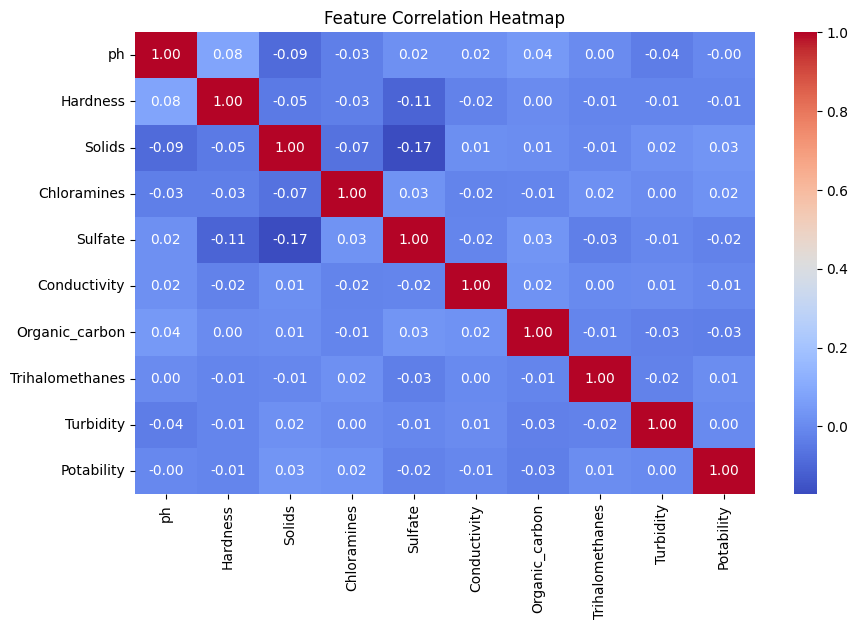

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## Handling Missing Values

In [ ]:
# check for null values
df.isna().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [ ]:
missing=df.isna().sum(axis=1)/df.shape[1] *100
missing.value_counts()

,count
0.0,2011
10.0,1105
20.0,151
30.0,9


In [ ]:
# Handlling Null Values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(df)
imputed_data = pd.DataFrame(imp_mean.transform(df),columns=df.columns)

imputed_data.isnull().sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


## Over-Sampling Technique

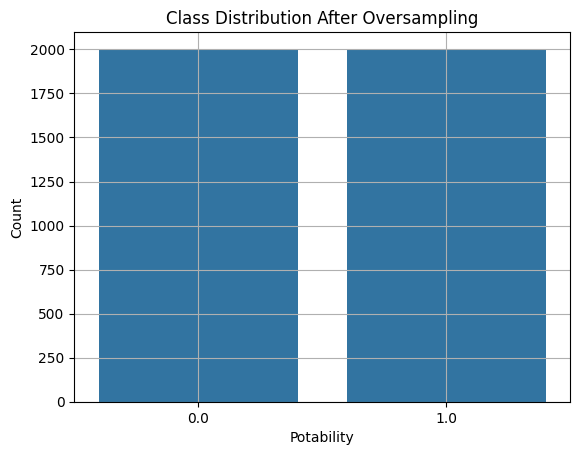

In [ ]:
# Separate majority and minority
df_majority = imputed_data[imputed_data['Potability'] == 0]
df_minority = imputed_data[imputed_data['Potability'] == 1]

# Upsample minority
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combine into upsampled DataFrame
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# ✅ Visualize class balance
sns.countplot(data=df_upsampled, x='Potability')
plt.title("Class Distribution After Oversampling")
plt.xlabel("Potability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Split features and labels
X = df_upsampled.drop('Potability', axis=1)
y = df_upsampled['Potability']


## RandomForest Classifier

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a reduced parameter grid for performance
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Evaluate on test set
pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

# Cross-validation on full dataset
cv_scores = cross_val_score(best_rf, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", np.mean(cv_scores))

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       415
         1.0       0.84      0.84      0.84       385

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800

Confusion Matrix:
 [[354  61]
 [ 61 324]]
Cross-validation scores: [0.81       0.86       0.8525     0.8675     0.85       0.845
 0.78696742 0.84711779 0.86716792 0.86466165]
Average CV score: 0.8450914786967418
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Split your data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Reduced but effective grid
param_grid = {
    'n_estimators': [100, 200, 300],     # explore more trees
    'max_depth': [4, 6],                 # control model complexity
    'learning_rate': [0.05, 0.1],        # slower vs. faster learning
    'subsample': [0.8],                  # fixed for regularization
    'colsample_bytree': [0.8],           # fixed
    'reg_lambda': [1, 2]                 # regularization strength
}


#GridSearchCV setup
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Train
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

# Test set evaluation
pred = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("Classification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

# Cross-validation on full set
cv_scores = cross_val_score(best_xgb, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", np.mean(cv_scores))

# Best params
print("Best Parameters:", grid_search.best_params_)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.81625
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       400
         1.0       0.80      0.85      0.82       400

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800

Confusion Matrix:
 [[313  87]
 [ 60 340]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validation scores: [0.8075     0.8325     0.8325     0.84       0.7925     0.82
 0.7593985  0.79448622 0.82957393 0.85964912]
Average CV score: 0.8168107769423558
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'reg_lambda': 2, 'subsample': 0.8}


## LightGBM Classifier

In [ ]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🔧 Efficient hyperparameter grid for Colab (keeps fits under ~100)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10],
    'num_leaves': [31, 50],
    'min_child_samples': [10],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)
best_lgbm = grid_search.best_estimator_

# Test evaluation
pred = best_lgbm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("Classification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

# Cross-validation (on full dataset)
cv_scores = cross_val_score(best_lgbm, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", np.mean(cv_scores))

# Show best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 1598, number of negative: 1598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 3196, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g